<a href="https://colab.research.google.com/github/vbtsahu/data-deduplication/blob/main/data_deduplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time
import os

from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

<Axes: >

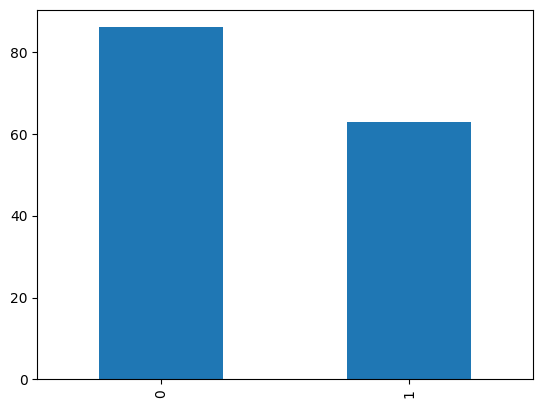

In [ ]:
data = pd.read_csv("Input.csv")
data['is_duplicate'].value_counts().plot(kind='bar')

In [ ]:
data

,ln,dob,gn,fn,is_duplicate
0,SMITH JR,01-03-1968,F,WILLIAM,0
1,ROTHMEYER JR,01-03-1968,F,WILLIAM,0
2,BLAND III,21-02-1962,F,WILLIAM,1
3,BLAND JR,21-02-1962,F,BILL,0
4,BLAND,21-02-1962,F,WILLIAM,1
...,...,...,...,...,...
144,PRERNA,17-11-1945,F,CHOPRA,0
145,PRERNA,07-10-1937,F,BHENDARKAR,0
146,PRERNA,07-10-1937,F,BHENDARKAR,1
147,ANSHUL,20-10-1953,F,SHARMA,0


In [ ]:
data.head()

,ln,dob,gn,fn,is_duplicate
0,SMITH JR,01-03-1968,F,WILLIAM,0
1,ROTHMEYER JR,01-03-1968,F,WILLIAM,0
2,BLAND III,21-02-1962,F,WILLIAM,1
3,BLAND JR,21-02-1962,F,BILL,0
4,BLAND,21-02-1962,F,WILLIAM,1


In [ ]:
#### The dob is converted to standard datetime format.

data.dob = pd.to_datetime(data.dob)

<ipython-input-5-2e774025483c>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data.dob = pd.to_datetime(data.dob)


In [ ]:
data.head()

,ln,dob,gn,fn,is_duplicate
0,SMITH JR,1968-01-03,F,WILLIAM,0
1,ROTHMEYER JR,1968-01-03,F,WILLIAM,0
2,BLAND III,1962-02-21,F,WILLIAM,1
3,BLAND JR,1962-02-21,F,BILL,0
4,BLAND,1962-02-21,F,WILLIAM,1


In [ ]:
data.dob.head(10)

0   1968-01-03
1   1968-01-03
2   1962-02-21
3   1962-02-21
4   1962-02-21
5   1962-02-21
6   1954-08-06
7   1954-08-06
8   1953-10-25
9   1953-10-25
Name: dob, dtype: datetime64[ns]

In [ ]:
data['name'] = data.fn + ' ' + data.ln

In [ ]:
import hashlib
import base64
data = data.assign(concat  = data.dob.astype(str) + data.gn + data.fn + data.ln)
data['hash']=data['concat'].astype(str).str.encode('UTF-8').apply(lambda x: base64.b64encode(hashlib.md5(x).digest()))
data
#data2=data
data.head()

,ln,dob,gn,fn,is_duplicate,name,concat,hash
0,SMITH JR,1968-01-03,F,WILLIAM,0,WILLIAM SMITH JR,1968-01-03FWILLIAMSMITH JR,b'wKkNy25BkUeZf06o2jJ6zw=='
1,ROTHMEYER JR,1968-01-03,F,WILLIAM,0,WILLIAM ROTHMEYER JR,1968-01-03FWILLIAMROTHMEYER JR,b'N2hmeSlSkC0bi/kbID2YdA=='
2,BLAND III,1962-02-21,F,WILLIAM,1,WILLIAM BLAND III,1962-02-21FWILLIAMBLAND III,b'LTt/hA+lZH7xu0hhuwL5og=='
3,BLAND JR,1962-02-21,F,BILL,0,BILL BLAND JR,1962-02-21FBILLBLAND JR,b'pQf0T22zXX76fYM0LCLMVg=='
4,BLAND,1962-02-21,F,WILLIAM,1,WILLIAM BLAND,1962-02-21FWILLIAMBLAND,b'XhFtQh04LCumDBUz5FGfxA=='


In [ ]:
#### A list of unique dates of birth and unique genders is obtained.

unique_dob = data.dob.unique()
unique_sex = data.gn.unique()
unique_hash = data.hash.unique()

In [ ]:
pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=b21755fdd283ceaccf727dcd7277cd2e939477788c1f086e2e4a7a70cd691cef
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [ ]:
import distance

In [ ]:
### Deduplication model function. This function learns by evaluating the Macro F1-score of classification on a passed range of values for maximum levenshtein score to classify an entry as duplicate.
start_h= time.time()

def deduplication_model(data, scoring_range = 10, step = 2):
    data['indices'] = list(range(len(data)))
    accuracy = []
    index = []
    final_step = 0
    for value in range(scoring_range):
        for i in unique_dob:
            for j in unique_sex:
                sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
                for a in range(len(sample)):
                    comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                    scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                    compare = [comparison.indices[x] for x in range(len(comparison))]
                    try:
                        if sample.indices[a]>compare[scores.index(min(scores))]:
                            score = np.min(scores)
                            if score<=value:
                                index.append(sample.indices[a])
                    except ValueError:
                        pass
        prediction = []
        for k in range(len(data)):
            if data.indices[k] in index:
                prediction.append(1)
            else:
                prediction.append(0)

        data['prediction'] = prediction
        print('F1-score after ',value, 'iterations : ', f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        accuracy.append(f1_score(data.is_duplicate, data.prediction, average = 'macro'))
        if len(accuracy)>1 and accuracy[-1] <= accuracy[-2]:
            final_step+=1
        if final_step>=step:
            value = value-final_step
            break

    index = []
    for i in unique_dob:
        for j in unique_sex:
            sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction, value

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.05, stratify = data.is_duplicate, random_state = 0)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
performance, levenshtein_value_optimum = deduplication_model(train, scoring_range = 10, step = 3)

<ipython-input-13-6f50f9887844>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


F1-score after  0 iterations :  0.6611481975967958


<ipython-input-13-6f50f9887844>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


F1-score after  1 iterations :  0.6825155783630937


<ipython-input-13-6f50f9887844>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


F1-score after  2 iterations :  0.6778147071042793


<ipython-input-13-6f50f9887844>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


F1-score after  3 iterations :  0.6663580246913581


<ipython-input-13-6f50f9887844>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


F1-score after  4 iterations :  0.6335796178343949


<ipython-input-13-6f50f9887844>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


In [ ]:
def deduplication_prediction(data, optimum_value):
    data['indices'] = list(range(len(data)))
    index = []
    for i in unique_dob:
        for j in unique_sex:
            sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)
            for a in range(len(sample)):
                comparison = sample[(sample.indices != sample.indices[a])].reset_index(drop = True)
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare = [comparison.indices[x] for x in range(len(comparison))]
                try:
                    if sample.indices[a]>compare[scores.index(min(scores))]:
                        score = np.min(scores)
                        if score<=optimum_value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [ ]:
predictions = deduplication_prediction(test, levenshtein_value_optimum)


<ipython-input-15-0f4babde35cd>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data[(data.dob == i)][(data.gn == j)].reset_index(drop = True)


In [ ]:
print('F1-score on test set:',accuracy_score(test.is_duplicate, predictions))


F1-score on test set: 0.625


In [ ]:
train['prediction'] = performance
test['prediction'] = predictions
dataset = pd.concat([train, test], axis = 0)
dataset = dataset[(dataset.prediction != 1)].reset_index(drop = True).drop(labels = ['name', 'is_duplicate', 'prediction', 'indices'], axis = 1)

In [ ]:
dataset.to_csv('output1.csv', index = False)
end_h = time.time()
tt2 = end_h - start_h
print('Time taken: ')
tt2

Time taken: 


4.08137059211731

In [ ]:
data1 = pd.read_csv('output1.csv')
data1.head()

,ln,dob,gn,fn,concat,hash
0,GRIFFIN JR,1937-07-05,M,DARL,1937-07-05MDARLGRIFFIN JR,b'EQynjeNAdMSOAU36BUwvPA=='
1,SHAILEE,1945-09-02,F,PATEL,1945-09-02FPATELSHAILEE,b'LNcw29ntnSEibJHUbg204g=='
2,LARSON JR,1939-09-06,M,HAROLD,1939-09-06MHAROLDLARSON JR,b'Z2LoJV0dBqXm2eTH4WMsaQ=='
3,DEEPIKA,1953-10-25,F,PADUKON,1953-10-25FPADUKONDEEPIKA,b'0/NYy6DojfiDzFZQa121Qg=='
4,LIND JR,1946-01-20,M,JOHN,1946-01-20MJOHNLIND JR,b'OGok+EeZ6LndZ52lT0nQBw=='


In [ ]:
data1

,ln,dob,gn,fn,concat,hash
0,GRIFFIN JR,1937-07-05,M,DARL,1937-07-05MDARLGRIFFIN JR,b'EQynjeNAdMSOAU36BUwvPA=='
1,SHAILEE,1945-09-02,F,PATEL,1945-09-02FPATELSHAILEE,b'LNcw29ntnSEibJHUbg204g=='
2,LARSON JR,1939-09-06,M,HAROLD,1939-09-06MHAROLDLARSON JR,b'Z2LoJV0dBqXm2eTH4WMsaQ=='
3,DEEPIKA,1953-10-25,F,PADUKON,1953-10-25FPADUKONDEEPIKA,b'0/NYy6DojfiDzFZQa121Qg=='
4,LIND JR,1946-01-20,M,JOHN,1946-01-20MJOHNLIND JR,b'OGok+EeZ6LndZ52lT0nQBw=='
...,...,...,...,...,...,...
91,GRIFFIN JR,1937-10-07,M,DARL,1937-10-07MDARLGRIFFIN JR,b'OxMT5FFSNsJ1W7UYpIY1Dg=='
92,RAJ,1945-10-05,M,SHARMA,1945-10-05MSHARMARAJ,b'z90E3U9EewPdVklwCsaOKw=='
93,SALTER JR,1968-01-03,F,WILLIAM,1968-01-03FWILLIAMSALTER JR,b'C/nkx7UR9QEB55yKI4sRPg=='
94,MELVIN JR,1937-07-10,M,HAROLD,1937-07-10MHAROLDMELVIN JR,b'YEBnvjKGoB5D/Tt584W95Q=='
